# Hong Kong Interbank Balance Plot

#### Imports

In [1]:
import pandas as pd
import requests
from requests.adapters import Retry, HTTPAdapter
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import json
import sqlite3


#### Globals

In [2]:
START = '2018-01-01'
END = str(pd.Timestamp.today().date())


#### Utility Functions

In [3]:
def url(Y, M, D):
    return (
        'https://www.hkma.gov.hk/eng/'
        'data-publications-and-research/data-and-statistics/'
        f'daily-monetary-statistics/{Y}/{M}/ms-{Y}{M}{D}/')


In [4]:
def interbank_balance(date):
    try:
        Y, M, D = date.split('-')
        sess = requests.Session()
        sess.mount('https://', HTTPAdapter(max_retries=Retry(total=50, backoff_factor=0.1)))
        resp = sess.get(url(Y, M, D))
        print(f'fetching {date}')
        soup = BeautifulSoup(resp.content)
        table = soup.select_one(
            '#interbank-liquidity + div + div div.collapsibles-accordion-content div.template-table table')
        trs = table.select('tr')
        td = trs[1].select('td')[1]
        clean_text = td.text.replace('mn', '').replace(
            '百萬', '').replace(',', '').strip()
        return float(clean_text)
    except (AttributeError, ):
        return None


#### Tests

In [5]:
for date in ['2022-06-01', '2022-08-01']:
    ib = interbank_balance(date)
    print(date, ib)


fetching 2022-06-01
2022-06-01 319990.0
fetching 2022-08-01
2022-08-01 165158.0


#### Fetch

If connection is banned, wait for a while and run this cell again. Program will only re-download failed fetch.

In [6]:
dates = [str(d.date())
         for d in pd.date_range(START, END)]
with sqlite3.connect('data.sqlite') as conn:
    cursor = conn.cursor()
    for d in dates:
        cursor.execute(f"SELECT * from interbank where Date='{d}'")
        rows = cursor.fetchall()
        if len(rows) == 0:
            val = interbank_balance(d)
            val = val if val is not None else 'NULL'
            cursor.execute(f'INSERT OR REPLACE INTO interbank (Date, Balance) VALUES ("{d}", {val})')
    conn.commit()

fetching 2025-04-24
fetching 2025-04-25
fetching 2025-04-26
fetching 2025-04-27
fetching 2025-04-28
fetching 2025-04-29
fetching 2025-04-30
fetching 2025-05-01
fetching 2025-05-02
fetching 2025-05-03
fetching 2025-05-04
fetching 2025-05-05
fetching 2025-05-06
fetching 2025-05-07
fetching 2025-05-08
fetching 2025-05-09
fetching 2025-05-10
fetching 2025-05-11
fetching 2025-05-12
fetching 2025-05-13
fetching 2025-05-14
fetching 2025-05-15
fetching 2025-05-16
fetching 2025-05-17
fetching 2025-05-18
fetching 2025-05-19
fetching 2025-05-20
fetching 2025-05-21
fetching 2025-05-22
fetching 2025-05-23
fetching 2025-05-24
fetching 2025-05-25
fetching 2025-05-26
fetching 2025-05-27
fetching 2025-05-28
fetching 2025-05-29
fetching 2025-05-30
fetching 2025-05-31
fetching 2025-06-01
fetching 2025-06-02
fetching 2025-06-03
fetching 2025-06-04
fetching 2025-06-05
fetching 2025-06-06
fetching 2025-06-07
fetching 2025-06-08
fetching 2025-06-09
fetching 2025-06-10
fetching 2025-06-11
fetching 2025-06-12


#### Plot

<Axes: title={'center': 'Hong Kong Interbank Balalnce'}, ylabel='million HKD'>

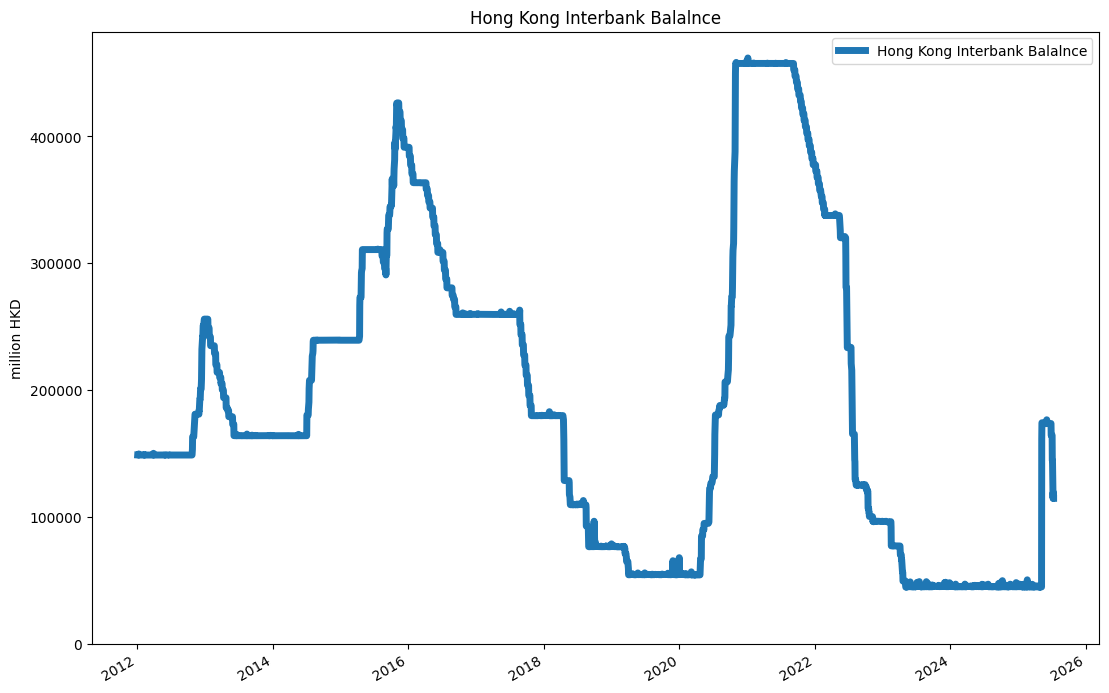

In [7]:
with sqlite3.connect('data.sqlite') as conn:
    cursor = conn.cursor()
    cursor.execute('SELECT * from interbank')
    data = cursor.fetchall()

clean = {d: v for d, v in dict(data).items() if v}
series = pd.Series(clean.values(),
                   index=pd.to_datetime(list(clean.keys())),
                   name='Hong Kong Interbank Balalnce').sort_index()
fig, ax = plt.subplots(1, 1, figsize=(13, 9))
series.plot(ax=ax, ylim=(0, None), title=series.name,
            legend=series.name, ylabel='million HKD', lw=5)


#### Recent

In [8]:
series.sort_index().iloc[-20:]

2025-06-12    173483
2025-06-13    173483
2025-06-16    173483
2025-06-17    173483
2025-06-18    173464
2025-06-19    173464
2025-06-20    173464
2025-06-23    173464
2025-06-24    173464
2025-06-25    173518
2025-06-26    173518
2025-06-27    164098
2025-06-30    164098
2025-07-02    164192
2025-07-03    144175
2025-07-04    144175
2025-07-07    114541
2025-07-08    119209
2025-07-09    114497
2025-07-10    114497
Name: Hong Kong Interbank Balalnce, dtype: int64